In [89]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [90]:
PROCESSED_PATH = "../data/processed/"
TIME_COLUMN = 'timestamp'

df = pd.read_csv(os.path.join(PROCESSED_PATH, 'model_ready_dataset_5min.csv'),
                 parse_dates=[TIME_COLUMN]).set_index(TIME_COLUMN)


df = df.dropna()
df.head()

RTM_CONG_PRC  RTM_ENE_PRC  RTM_LOSS_PRC    RTM_PRC  \
timestamp                                                                       
2023-01-02 14:00:00+00:00           0.0    213.26000           0.0  213.26000   
2023-01-02 14:05:00+00:00           0.0    197.67000           0.0  197.67000   
2023-01-02 14:10:00+00:00           0.0    195.06000           0.0  195.06000   
2023-01-02 14:15:00+00:00           0.0    207.27322           0.0  207.27322   
2023-01-02 14:20:00+00:00           0.0    244.96500           0.0  244.96500   

                           DAM_CONG_PRC  DAM_ENE_PRC  DAM_GHG_PRC  \
timestamp                                                           
2023-01-02 14:00:00+00:00           0.0     151.1542          0.0   
2023-01-02 14:05:00+00:00           0.0     151.1542          0.0   
2023-01-02 14:10:00+00:00           0.0     151.1542          0.0   
2023-01-02 14:15:00+00:00           0.0     151.1542          0.0   
2023-01-02 14:20:00+00:00           0.0     151.1542          0.0   

                           DAM_LOSS_PRC    DAM_PRC  2DA_LOAD  ...  \
timestamp                                                     ...   
2023-01-02 14:00:00+00:00      -2.32777  148.82643   8837.71  ...   
2023-01-02 14:05:00+00:00      -2.32777  148.82643   8715.03  ...   
2023-01-02 14:10:00+00:00      -2.32777  148.82643   8756.71  ...   
2023-01-02 14:15:00+00:00      -2.32777  148.82643   8789.51  ...   
2023-01-02 14:20:00+00:00      -2.32777  148.82643   8874.72  ...   

                           RTM_PRC_lag90min  RTM_PRC_lag24hr  2DA_LOAD_lag1  \
timestamp                                                                     
2023-01-02 14:00:00+00:00          216.0024        115.95011        8565.53   
2023-01-02 14:05:00+00:00          233.6136        115.95011        8837.71   
2023-01-02 14:10:00+00:00          213.2912        115.95011        8715.03   
2023-01-02 14:15:00+00:00          218.6124        115.95011        8756.71   
2023-01-02 14:20:00+00:00          218.1324        114.72000        8789.51   

                           RTPD_DMND_lag1  hour  dayofweek  month  year  \
timestamp                                                                 
2023-01-02 14:00:00+00:00         8490.66     6          0      1  2023   
2023-01-02 14:05:00+00:00         8690.41     6          0      1  2023   
2023-01-02 14:10:00+00:00         8690.41     6          0      1  2023   
2023-01-02 14:15:00+00:00         8690.41     6          0      1  2023   
2023-01-02 14:20:00+00:00         8789.51     6          0      1  2023   

                           is_weekend  is_night  
timestamp                                        
2023-01-02 14:00:00+00:00       False     False  
2023-01-02 14:05:00+00:00       False     False  
2023-01-02 14:10:00+00:00       False     False  
2023-01-02 14:15:00+00:00       False     False  
2023-01-02 14:20:00+00:00       False     False  

[5 rows x 25 columns]

In [91]:
# define structure for input and target

quantiles = [0.05, 0.95, 0.5]

class DailySequenceDataset(Dataset):
    def __init__(self, input_data, target_data):
        """
        input_data: shape (num_days, seq_len, num_features)
        target_data: shape (num_days, seq_len)
        """
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        x = self.input_data[idx]
        y = self.target_data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
# Define the LSTM model
class DailyPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(DailyPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, len(quantiles))

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out.squeeze(-1)

class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.q = quantile

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        return torch.mean(torch.max(self.q * error, (self.q - 1) * error))

In [92]:
# Create derived features
df['RTM-DAM'] = df['RTM_PRC'] - df['DAM_PRC'] #difference between DAM and RTM, used as fitting target


In [93]:
# Define features and target
target = "RTM-DAM"
features = [
    "DAM_PRC",
    "2DA_LOAD",
    #"2DA_LOAD_lag1",
    #"RTPD_DMND",
    #"RTPD_DMND_lag1",
    #'RTPD_Forecast_dmnd_diff',
    "hour",
    "dayofweek",
    "month",
    "year",
    "is_weekend",
    "is_night",
    "RTM_PRC_lag24hr",
]

#Day of features
day_of_features = [
    "RTPD_PRC",
    "RTM_PRC_lag75min",
    "RTM_PRC_lag80min",
    "RTM_PRC_lag85min",
    "RTM_PRC_lag90min",
]

#features += day_of_features

In [94]:

# Helper function to prepare sequences from a long dataframe
def prepare_daily_sequences(df, feature_cols, target_col, samples_per_day=288):
    """
    df: time-indexed dataframe
    feature_cols: columns to use as features
    target_col: column to use as target
    """
    features = []
    targets = []
    num_days = len(df) // samples_per_day

    for i in range(num_days - 1):
        day_start = i * samples_per_day
        day_end = (i + 1) * samples_per_day
        next_day_end = (i + 2) * samples_per_day

        x = df.iloc[day_start:day_end][feature_cols].values
        y = df.iloc[day_end:next_day_end][target_col].values

        if len(x) == samples_per_day and len(y) == samples_per_day:
            features.append(x)
            targets.append(y)

    return np.stack(features), np.stack(targets)


In [95]:
# Split into train/test and scale data

from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaled = pd.DataFrame(x_scaler.fit_transform(df[features]), columns=df[features].columns)
y_scaled = pd.DataFrame(y_scaler.fit_transform(df[[target]]), columns=df[[target]].columns)
x_scaled.index = df.index
y_scaled.index = df.index

df_scaled = x_scaled.join([y_scaled], how='outer')

train_size = int(len(df_scaled) * 0.8)

train_df = df_scaled.iloc[:train_size]
start = np.where((train_df.index.hour == 8) & (train_df.index.minute == 0))[0][0]
end = np.where((train_df.index.hour == 7) & (train_df.index.minute == 55))[0][-1]
train_df = train_df.iloc[start:end+1]

test_df = df_scaled.iloc[train_size:]
start = np.where((test_df.index.hour == 8) & (test_df.index.minute == 0))[0][0]
end = np.where((test_df.index.hour == 7) & (test_df.index.minute == 55))[0][-1]
test_df = test_df.iloc[start:end+1]

X_train, y_train = prepare_daily_sequences(train_df, features, target)
X_test, y_test = prepare_daily_sequences(test_df, features, target)

#shuffle days randomly
train_set = np.dstack((X_train, y_train))
test_set = np.dstack((X_test, y_test))
full_set = np.concatenate((train_set, test_set), axis=0)
np.random.seed(1)
np.random.shuffle(full_set)

#re-split train/test data
train_size = int(len(full_set) * 0.8)
X_train = full_set[:train_size,:,:-1]
X_test = full_set[train_size:,:,:-1]
y_train = full_set[:train_size,:,-1]
y_test = full_set[train_size:,:,-1]
print('train', X_train.shape)
print('test', X_test.shape)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

train (718, 288, 9)
test (180, 288, 9)


In [96]:
# Hyperparameters
input_size = len(features)           # Number of features per timestep
hidden_size = 64
batch_size = 16
num_epochs = 50
learning_rate = 0.001

# Load your actual data here
train_dataset = DailySequenceDataset(X_train, y_train)  # shape: (N, 288, input_size)
test_dataset = DailySequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = DailyPricePredictor(input_size=input_size, hidden_size=hidden_size)
#criterion = nn.MSELoss()
criterion_list = [QuantileLoss(q) for q in quantiles]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = 0
        for i, q in enumerate(quantiles):
            pred_q = outputs[:,:,i]
            loss += criterion_list[i](pred_q, targets)
        #loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = 0
            for i, q in enumerate(quantiles):
                pred_q = outputs[:,:,i]
                loss += criterion_list[i](pred_q, targets)
            #loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}")


Epoch 1/50, Train Loss: 0.3975, test Loss: 0.3082
Epoch 2/50, Train Loss: 0.3207, test Loss: 0.3019
Epoch 3/50, Train Loss: 0.3148, test Loss: 0.2957
Epoch 4/50, Train Loss: 0.3123, test Loss: 0.2948
Epoch 5/50, Train Loss: 0.3085, test Loss: 0.2943
Epoch 6/50, Train Loss: 0.3051, test Loss: 0.2934
Epoch 7/50, Train Loss: 0.3038, test Loss: 0.2912
Epoch 8/50, Train Loss: 0.3011, test Loss: 0.2929
Epoch 9/50, Train Loss: 0.3005, test Loss: 0.2929
Epoch 10/50, Train Loss: 0.2991, test Loss: 0.2903
Epoch 11/50, Train Loss: 0.2981, test Loss: 0.2927
Epoch 12/50, Train Loss: 0.2965, test Loss: 0.2906
Epoch 13/50, Train Loss: 0.2962, test Loss: 0.2897
Epoch 14/50, Train Loss: 0.2951, test Loss: 0.2950
Epoch 15/50, Train Loss: 0.2947, test Loss: 0.2897
Epoch 16/50, Train Loss: 0.2932, test Loss: 0.2915
Epoch 17/50, Train Loss: 0.2939, test Loss: 0.2903
Epoch 18/50, Train Loss: 0.2916, test Loss: 0.2906
Epoch 19/50, Train Loss: 0.2900, test Loss: 0.2914
Epoch 20/50, Train Loss: 0.2897, test Lo

In [112]:
def predict_test_set():
    # Reshape for batch dimension
    x_input = X_test
    
    x_tensor = torch.tensor(x_input, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(x_tensor)
        
    n_days = x_input.shape[0]
    pts = x_input.shape[1]
    
    y_pred = y_scaler.inverse_transform(y_pred.reshape([n_days*pts, -1]))
    y_act = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    r = x_input.reshape([n_days*pts, -1])
    X_vals = x_scaler.inverse_transform(r)

    lower_bound = y_pred[:,0]
    upper_bound = y_pred[:,1]
    y_pred = y_pred[:,2]
    
    return X_vals, y_act, (y_pred, lower_bound, upper_bound)
    
def predict_2025():
    # Reshape for batch dimension
    x_input = test_set[:,:,:-1]
    y_test = test_set[:,:,-1]
    
    x_tensor = torch.tensor(x_input, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(x_tensor)
        
    n_days = x_input.shape[0]
    pts = x_input.shape[1]
    
    y_pred = y_scaler.inverse_transform(y_pred.reshape([n_days*pts, -1]))
    y_act = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    r = x_input.reshape([n_days*pts, -1])
    X_vals = x_scaler.inverse_transform(r)

    lower_bound = y_pred[:,0]
    upper_bound = y_pred[:,1]
    y_pred = y_pred[:,2]
    
    return X_vals, y_act, (y_pred, lower_bound, upper_bound)

In [121]:
X_vals, y_act, (y_pred, lower_bound, upper_bound) = predict_test_set()
#X_vals, y_act, (y_pred, lower_bound, upper_bound) = predict_2025()
dam = X_vals[:,0]

y_mean_95 = upper_bound
y_mean_05 = lower_bound
y_mean_50 = y_pred


2024-12-25 08:00:00+00:00


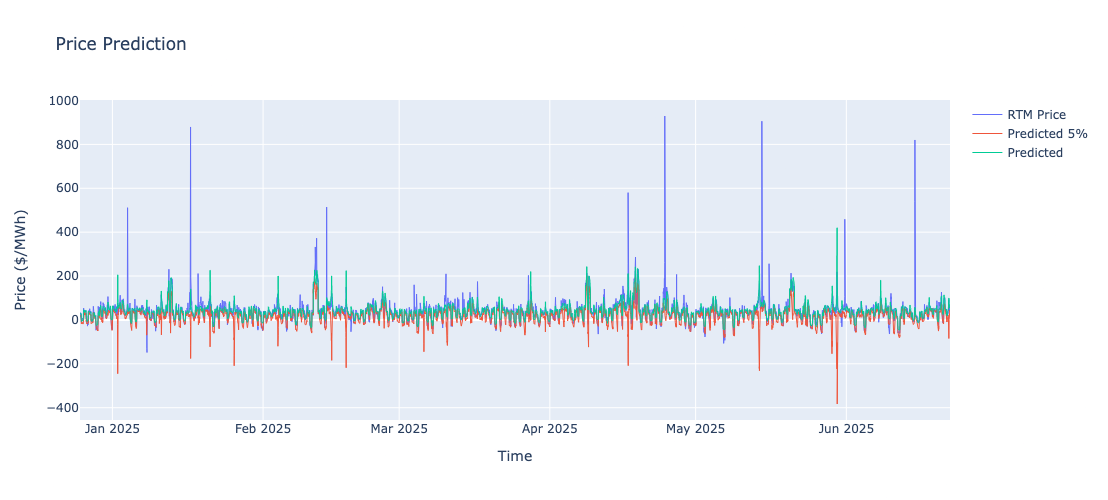

In [125]:
import plotly.graph_objects as go

time = test_df.index
#time = test_df.index.tz_convert('US/Pacific')
print(time[0])


fig = go.Figure()

fig.add_trace(go.Scatter(x=time, y=y_act + dam, mode='lines', name='RTM Price', line=dict(width=1)))
#fig.add_trace(go.Scatter(x=time, y=y_mean_95 + dam, mode='lines', name='Predicted 95%', line=dict(width=1)))
fig.add_trace(go.Scatter(x=time, y=y_mean_05 + dam, mode='lines', name='Predicted 5%', line=dict(width=1)))
#fig.add_trace(go.Scatter(x=time, y=y_mean_50 + dam, mode='lines', name='Predicted', line=dict(width=1)))
fig.add_trace(go.Scatter(x=time, y=dam, mode='lines', name='Predicted', line=dict(width=1)))

fig.update_layout(title='Price Prediction',
                  xaxis_title='Time',
                  width=1100, 
                  height=500,
                  yaxis_title='Price ($/MWh)',)
fig.show()


## Model Quantification

In [126]:
# Measure dataset coverage

upper_coverage = (y_act <= y_mean_95).mean()
print(f'Upper Coverage: {upper_coverage:.{3}}')

lower_coverage = (y_act >= y_mean_05).mean()
print(f'Lower Coverage: {lower_coverage:.{3}}')

coverage = ((y_act >= y_mean_05) & (y_act <= y_mean_95)).mean()
print(f'Total Coverage: {coverage:.{3}}')

Upper Coverage: 0.948
Lower Coverage: 0.92
Total Coverage: 0.868


In [127]:
# Measure prediction spread

avg_width = (y_mean_95 - y_mean_05).mean()
print(f'Average Prediction Width: {avg_width:.{3}} $/MWh')

Average Prediction Width: 39.9 $/MWh
